In [1]:
# inline for plots to show up in jupyter notebook
%matplotlib inline

# Some dependencies used in my project
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
import os

In [2]:
FACE_DIR = os.path.join(os.getcwd(),"faces") 
print("Face Dir is- ",FACE_DIR)

Face Dir is-  C:\Users\SilC\A hybrid EigenFace and Viola Jones algorithm\EigenFaces-master\faces


In [3]:

face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

# This function reads image from the given image path 
def read_im(path):
  im = PIL.Image.open(path)
  im = np.array(im)
  return im

# As working with images, this function plots any binnary image
def show_im(image):
  plt.imshow(image,cmap='gray')
  plt.show()

# This function uses the frontal haarcascade defined above to detect faces in given images
def find_faces(gray):
  faces = face_cascade.detectMultiScale(gray, 1.3, 3)
  return faces

# This function takes the image and found faces as an array of tuples and then plots them on the image
def draw_faces(image,faces):
  for face in faces:
    image = cv.rectangle(image,(face[0],face[1]) , (face[0] + face[2],face[1] + face[3]),(100,100,100),4)
  return image


In [4]:
# For flipping the photos 
"""
for dirpath, dirnames, filenames in os.walk(FACE_DIR):
    for file in filenames:
        im = read_im(os.path.join(dirpath,file)) 
        im = cv.flip(im,1)
        # show_im(im)
        new_file = str(int(file.split('.')[0])+11) + '.png'
        # print(new_file)
        loc = os.path.join(dirpath,new_file)
        print(loc)

"""

"\nfor dirpath, dirnames, filenames in os.walk(FACE_DIR):\n    for file in filenames:\n        im = read_im(os.path.join(dirpath,file)) \n        im = cv.flip(im,1)\n        # show_im(im)\n        new_file = str(int(file.split('.')[0])+11) + '.png'\n        # print(new_file)\n        loc = os.path.join(dirpath,new_file)\n        print(loc)\n\n"

In [5]:
SUB = 15        # Number of subjects
IPS = 22        # Images per subject
N = 100         # Width and Height of images
m = SUB*IPS     # Total Images

face_mat = np.zeros((m,N,N))   # To store images

# Getting all images into the face matrix
count = 0
for dirpath, dirnames, filenames in os.walk(FACE_DIR):
    for file in filenames:
        if count<m:
            face_mat[count] = read_im(os.path.join(dirpath,file))
            count += 1

In [6]:
def train_test_split(face_mat,Train_per_sub = 20):
    # Train test Split:
    Train_ims = Train_per_sub*SUB           # Total Train Ims
    Test_per_sub = IPS - Train_per_sub      # Test Images per subject
    Test_ims = Test_per_sub*SUB             # Total Test Ims

    train_mat = np.zeros((Train_ims,N,N))   # Train Matrix
    test_mat = np.zeros((Test_ims,N,N))     # Test Matrix
    train_count = 0                         # Train counter
    test_count = 0                          # Test counter

    for count,face in enumerate(face_mat):
        if count%IPS <Test_per_sub:
            # print("TEST",count,test_count)
            test_mat[test_count] = face_mat[count]
            test_count += 1
        
        else:
            # print("TRAIN",count,train_count)
            train_mat[train_count] = face_mat[count]
            train_count += 1
    return train_mat,test_mat

Shape of A is  (10000, 300)
Shape of A_avg is  (10000,)
This is the average face-


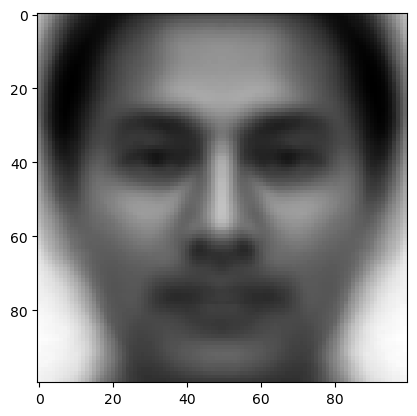

Phi_1 shape is  (10000, 300)


In [7]:
train_per_sub = 20              # Train images per subject (max 22)
m = train_per_sub*SUB           # Total ims
face_mat /= 255                 # Making images out of 1
# Train Test split
train_mat, test_mat = train_test_split(face_mat,train_per_sub)

# We need A of shape (N*N,m)
A = np.reshape(train_mat,(m,N*N)).T
print("Shape of A is ",A.shape)

# Calculating Average Face
A_avg = np.mean(A,axis=1)
print("Shape of A_avg is ",A_avg.shape)
print("This is the average face-")
show_im(np.reshape(A_avg,(N,N)))

# Calculating Normalized Faces
Phi_1 = (A.T - A_avg.T).T
print("Phi_1 shape is ",Phi_1.shape)

Cov_mxm shape is  (300, 300)
These are the 20 most important eigen values - 


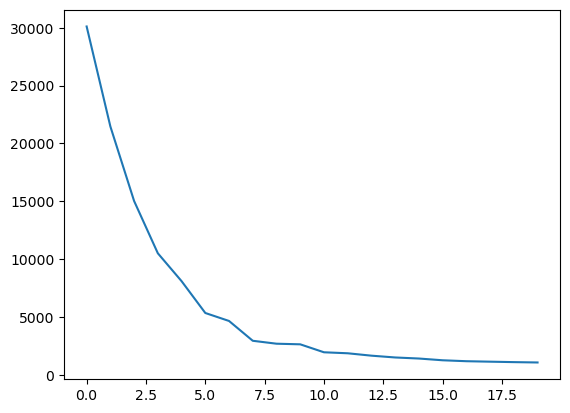

We choose 204 principal components to capture 0.99 variance out of mxm covariance.


In [8]:
# Calculating m*m covarience matrices and their eigen values
Cov_mbym = np.dot(Phi_1.T,Phi_1)
print("Cov_mxm shape is ",Cov_mbym.shape)

# Finding the Eigen vectors of the Covariance Matrix
eig,eig_vec = np.linalg.eig(Cov_mbym)
eig,eig_vec = np.real(eig),np.real(eig_vec)
print("These are the 20 most important eigen values - ")
plt.plot(eig[:20])
plt.show()

# Choosing number of principal components
variance = 0.99
for k in range(len(eig)):
  if np.sum(eig[:k])/np.sum(eig) > variance:
    print("We choose {} principal components to capture {} variance out of mxm covariance.".format(k,variance))
    break

(204,) (10000, 204)
These are the top 5 eigen faces


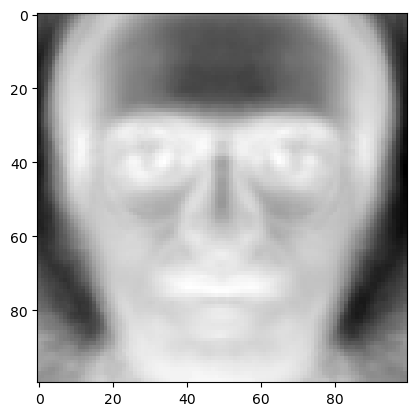

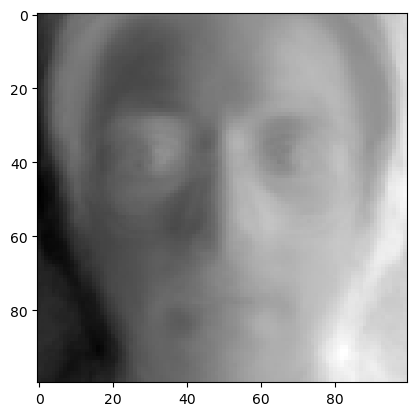

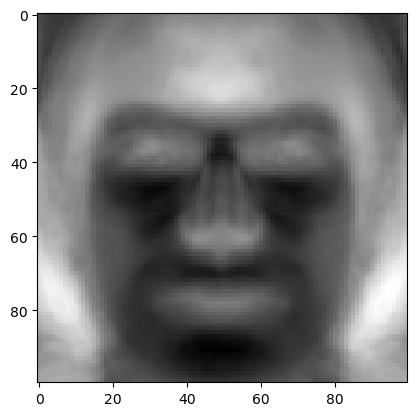

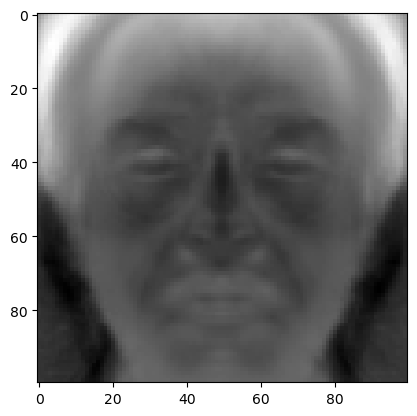

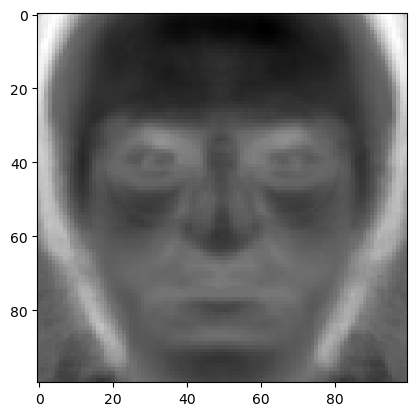

In [9]:
# Selecting K values out of m and dotting N.Nxm with mxk 
eig_k,eig_k_vec = eig[:k],np.dot(Phi_1,eig_vec[:,:k])
print(eig_k.shape,eig_k_vec.shape)

print("These are the top 5 eigen faces")
for i in range(5):
  show_im(np.reshape(eig_k_vec.T[i],(100,100)))


In [10]:
# Projecting the Normalized images on to the K vector Space
embedded = np.dot(Phi_1.T,eig_k_vec)
print("Embedding for all faces", embedded.shape)


Embedding for all faces (300, 204)


In [11]:
# Defining the distance function
def cos_sim(a,b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

Here the white pixels are images that are matched, The ground truth should look like square pixels in the diagnol


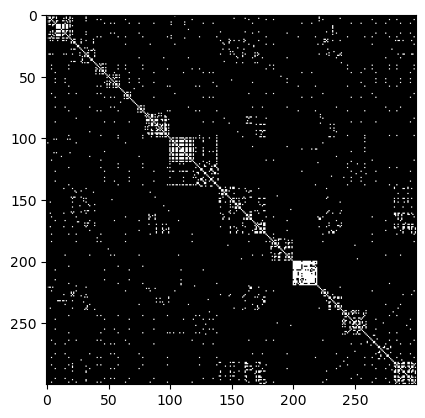

In [12]:
# Plotting the image matching covariance matrix
cov = np.dot(embedded,embedded.T)
cos_mat = np.zeros((m,m))
thres = 0.85
for i in range(m):
  for j in range(m):
    if cos_sim(embedded[i],embedded[j])>thres:
      cos_mat[i,j] = 1

print("Here the white pixels are images that are matched, The ground truth should look like square pixels in the diagnol")
show_im(cos_mat)


In [13]:
# Defining a function to return a face for given image embedding that has most number of minimum distances
def check_face_all(face,faces,thres=0.6):
    check = np.zeros(SUB)
    
    for i in range(SUB):
        for j in range(train_per_sub):
            if cos_sim(face,faces[i*train_per_sub +j])>thres:
                check[i] += 1
    return np.argmax(check),check

In [14]:
# Defining a function to give face id of minimum distance
def check_face(face,embed):
    check = []
    for i in range(len(embed)):
        check.append(cos_sim(face,embed[i]))
    return np.argmax(check),check[np.argmax(check)]

In [15]:
thres = 0.83
# We check the train accuracy here of our eigen faces method

correct = 0
mat = np.zeros((2,2))

for i in range(SUB):
    for j in range(train_per_sub):
        # Here we have two accuracy metrics, by default we use max face matched for min distance. one can comment 
        # line one and uncomment line 2 to check the min distance face id.
        id,t = check_face_all(embedded[i*train_per_sub+ j],embedded,thres)
        # id,sim = check_face(embedded[i*train_per_sub + j],emb_avg)   
        if id == i: #id==i: #
            correct += 1
print("Correct = {}, Wrong = {}".format(correct,300-correct))
print("Accuracy = ",correct/300)

Correct = 230, Wrong = 70
Accuracy =  0.7666666666666667


In [16]:
# We use the this block to check the testing accuracy

# Setting the threshold
thres = 0.83

test_count = SUB*IPS - m
test_per_sub = IPS - train_per_sub
print("test_mat shape is ",test_mat.shape)

# We change the test mat to (m,N*N)
test_A = np.reshape(test_mat,(test_count,N*N)).T
print('Test_A shape is ',test_A.shape)

# We normalize the test faces
test_phi_1 = (test_A.T - A_avg.T).T
print("test_phi_1 shape is",test_phi_1.shape)

# We project the test images into our k space
test_embed = np.dot(test_phi_1.T,eig_k_vec)
print("test_embed shape is ",test_embed.shape)

# We check the accuracy
correct = 0
for i in range(SUB):
    for j in range(test_per_sub):
        id,t = check_face_all(test_embed[i*test_per_sub+ j],embedded,thres)
        print("For test image of subject-{}, {} images found for {} face".format(str(i+1).zfill(2),str(int(max(t))).zfill(2),str(np.argmax(t)+1).zfill(2)))
        if id == i:
            correct += 1
print("Correct = {}, Wrong = {}".format(correct,test_count-correct))
print("Accuracy = ",correct/test_count)




test_mat shape is  (30, 100, 100)
Test_A shape is  (10000, 30)
test_phi_1 shape is (10000, 30)
test_embed shape is  (30, 204)
For test image of subject-01, 09 images found for 01 face
For test image of subject-01, 08 images found for 01 face
For test image of subject-02, 06 images found for 02 face
For test image of subject-02, 01 images found for 08 face
For test image of subject-03, 05 images found for 03 face
For test image of subject-03, 00 images found for 01 face
For test image of subject-04, 01 images found for 04 face
For test image of subject-04, 00 images found for 01 face
For test image of subject-05, 10 images found for 05 face
For test image of subject-05, 12 images found for 05 face
For test image of subject-06, 14 images found for 06 face
For test image of subject-06, 14 images found for 06 face
For test image of subject-07, 07 images found for 07 face
For test image of subject-07, 01 images found for 07 face
For test image of subject-08, 08 images found for 08 face
For 

In [17]:
print("Correct = {}, Wrong = {}".format(correct,test_count-correct))
print("Accuracy = ",correct/test_count)


Correct = 27, Wrong = 3
Accuracy =  0.9
